In [135]:
# Ralph's orginal notebook with Laurel's work appended
# Change file locations as needed

In [98]:
# from ralph_tools import *
import h5py
import re
import os
from matplotlib_scalebar.scalebar import ScaleBar
import time
import numpy as np
from glob import glob
# from igor2 import binarywave
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [99]:
def jet_with_zero_transparent(n_colors=256):
    """
    Create a 'jet' colormap where only the lowest value (0) is fully transparent,
    and all other values are fully opaque.
    """
    base = plt.get_cmap('jet', n_colors)
    colors = base(np.arange(n_colors))
    
    # Make first color (lowest value) transparent, rest fully opaque
    colors[:, -1] = 1.0
    colors[:20, -1] = 0.0
    
    return ListedColormap(colors)


def unitize(ux, uy, uz, eps=1e-12):
    ux = np.asanyarray(ux, dtype=float)
    uy = np.asanyarray(uy, dtype=float)
    uz = np.asanyarray(uz, dtype=float)
    U = np.stack((ux, uy, uz), axis=-1)  # (H,W,3)
    mag = np.linalg.norm(U, axis=-1)
    valid = mag > eps
    mag_safe = mag.copy()
    mag_safe[~valid] = 1.0
    U_dir = U / mag_safe[..., None]
    U_dir[~valid] = 0.0
    return U_dir, valid

def angle_between_unit(a, b):
    # a,b shape (...,3)
    dot = np.sum(a * b, axis=-1)
    dot = np.clip(dot, -1.0, 1.0)
    return np.arccos(dot)

def most_common_opposite_angle_map_discrete(
        ux, uy, uz,
        radius=3,
        bin_width=np.pi/36,   # default: 5 degree bins
        min_pairs_required=4,
        eps=1e-12
    ):
    """
    For each pixel compute the most common angle (radians) between opposite discrete pixel pairs
    within integer offsets in a radius.

    Parameters
    ----------
    ux, uy, uz : 2D arrays (complex or real)
        Vector field components.
    radius : int
        Max integer radius to consider. Offsets considered are all integer (dy,dx) with
        dy^2 + dx^2 <= radius^2 and not (0,0).
    bin_width : float
        Histogram bin width in radians (must evenly divide pi for convenience but not required).
    min_pairs_required : int
        Minimum valid opposite pairs required to return a mode; otherwise result is np.nan.
    eps : float
        Small value to avoid division by zero when normalizing.

    Returns
    -------
    mode_map : float array (H,W)
        Per-pixel most common angle (radians) — center of modal bin; np.nan where insufficient pairs.
    modal_count_map : int array (H,W)
        Count of samples inside the modal bin for each pixel.
    total_pairs_map : int array (H,W)
        Total number of valid opposite pairs used for each pixel.
    bin_centers : 1D array
        The centers of histogram bins used (useful for interpretation).
    """
    # 1) Use real parts
    ux_r = np.real(ux)
    uy_r = np.real(uy)
    uz_r = np.real(uz)

    H, W = ux_r.shape

    # 2) Precompute unit vectors and valid mask
    U_dir, valid_vec_mask = unitize(ux_r, uy_r, uz_r, eps=eps)  # shape (H,W,3)

    # 3) Prepare integer offset list (dy,dx) within radius (exclude 0,0).
    offsets = []
    r2 = radius * radius
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            if dy == 0 and dx == 0:
                continue
            if dy*dy + dx*dx <= r2:
                # ensure we only keep one of the opposite pairs set later; we'll use both p+(dy,dx) & p-(dy,dx)
                # Keep every offset; opposite is just negative offset.
                offsets.append((dy, dx))
    # offsets contains duplicates of opposites; that's fine because each offset will generate one opposite pair.

    # 4) Histogram bin edges and centers (0..pi)
    # Ensure last edge >= pi
    n_bins = int(np.ceil(np.pi / bin_width))
    bin_edges = np.linspace(0.0, n_bins * bin_width, n_bins + 1)
    # if bin_edges[-1] < pi: extend one more bin to include pi
    if bin_edges[-1] < np.pi:
        bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
        n_bins = len(bin_edges) - 1
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Prepare outputs
    mode_map = np.full((H, W), np.nan, dtype=float)
    modal_count_map = np.zeros((H, W), dtype=int)
    total_pairs_map = np.zeros((H, W), dtype=int)

    # 5) Iterate over pixels (can be slow for very large images)
    for iy in range(H):
        for ix in range(W):
            angles_collected = []

            # For each integer offset, check both endpoints are in-bounds and valid vectors
            for (dy, dx) in offsets:
                y_plus = iy + dy
                x_plus = ix + dx
                y_minus = iy - dy
                x_minus = ix - dx

                # check bounds
                if (y_plus < 0 or y_plus >= H or x_plus < 0 or x_plus >= W or
                    y_minus < 0 or y_minus >= H or x_minus < 0 or x_minus >= W):
                    continue

                # check vector validity at both points
                if (not valid_vec_mask[y_plus, x_plus]) or (not valid_vec_mask[y_minus, x_minus]):
                    continue

                v_plus = U_dir[y_plus, x_plus, :]
                v_minus = U_dir[y_minus, x_minus, :]

                # compute angle
                ang = angle_between_unit(v_plus[None, :], v_minus[None, :])[0]
                # store
                angles_collected.append(ang)

            # end offsets loop

            total_pairs = len(angles_collected)
            total_pairs_map[iy, ix] = total_pairs

            if total_pairs >= min_pairs_required:
                counts, _ = np.histogram(angles_collected, bins=bin_edges)
                max_idx = np.argmax(counts)
                modal_count = counts[max_idx]
                modal_angle = bin_centers[max_idx]
                mode_map[iy, ix] = modal_angle
                modal_count_map[iy, ix] = int(modal_count)
            else:
                mode_map[iy, ix] = np.nan
                modal_count_map[iy, ix] = 0

    return mode_map, modal_count_map, total_pairs_map, bin_centers


In [100]:
file_loc = r'/Users/lw2/Documents/LASER'
base_filename = 'Image'
log_filename = 'Log_3DPFM'

In [101]:

os.chdir(file_loc)
with (h5py.File(base_filename+'.hf5', 'r')) as f:
    ux = f['3DPFM/ux'][:]
    uy = f['3DPFM/uy'][:]
    uz = f['3DPFM/uz'][:]
    
    priority = ['B', 'C', 'A', 'E']
    Cnt = next((x for x in priority if x in f.keys()), None)
    
    topo = f[Cnt+'/Channel_000/Channel_000/Channel_000'][:]
    scale = f[Cnt+'/Channel_000/Channel_000/original_metadata'].attrs['FastScanSize']/f[Cnt+'/Channel_000/Channel_000/original_metadata'].attrs['PointsLines']


In [102]:
mode_map, modal_count, total_pairs, bin_centers = most_common_opposite_angle_map_discrete(
    ux, uy, uz,
    radius=7,
    bin_width=np.pi/20,
    min_pairs_required=6
)


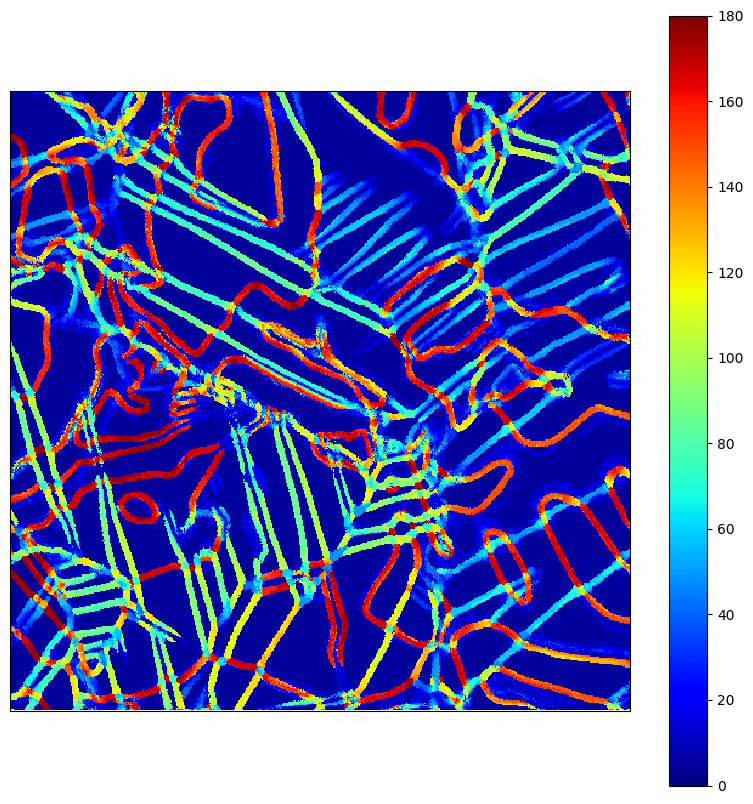

In [103]:
plt.figure(figsize=(10,10))

plt.imshow(mode_map*180/np.pi, vmin = 0, vmax = 180, cmap = 'jet', interpolation = 'none')
plt.xticks([])
plt.yticks([])
plt.colorbar()

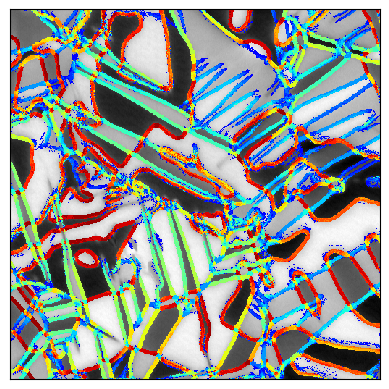

In [104]:

U_mag = np.sqrt(np.abs(ux)**2+np.abs(uy)**2+np.abs(uz)**2)
background_img = np.real(uz).copy()

angle_deg = mode_map * 180 / np.pi

jet_zero_transparent = jet_with_zero_transparent()

plt.imshow(background_img, cmap='binary_r', interpolation='none')

plt.imshow(angle_deg, vmin=0, vmax=180,
           cmap=jet_zero_transparent, interpolation='none')

plt.xticks([])
plt.yticks([])
#plt.colorbar(label="Angle (°)")
plt.show()


(0.0, 180.0)

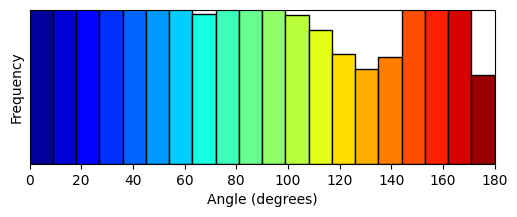

In [116]:



angle_deg_flatten = angle_deg.flatten()
angle_deg_flatten = angle_deg_flatten[~np.isnan(angle_deg_flatten)]


plt.figure(figsize=(6, 2))

# Histogram with fixed bins 0..180 (20 bins -> 9° each)
hist, bins = np.histogram(angle_deg_flatten, bins=20, range=(0, 180))

# Drop the first two bins
hist = hist[:]                # len = 18
left = bins[:-1]              # edges i=2..19 -> len = 18 (left edges)
right = bins[1:]               # edges i=3..20 -> len = 18 (right edges)
width = right - left           # len = 18
centers = 0.5 * (left + right) # len = 18

# Colors from jet mapped to 0..180
norm = mcolors.Normalize(vmin=0, vmax=180)
colors = cm.jet(norm(centers))

# Plot
plt.bar(left, hist, width=width, align='edge', edgecolor='black', color=colors)

# Optional colorbar
# sm = cm.ScalarMappable(cmap=cm.jet, norm=norm); sm.set_array([])
# plt.colorbar(sm, label='Angle (degrees)')

plt.xlabel('Angle (degrees)')
plt.ylabel('Frequency')
plt.yticks([])
plt.ylim([0, 5000])
plt.xlim([0,180])

#plt.savefig('AngleHist.png', dpi=180, bbox_inches='tight')
#plt.savefig('AngleHist.eps', bbox_inches='tight')
#plt.close()


In [106]:
# New stuff added by Laurel beyond this point

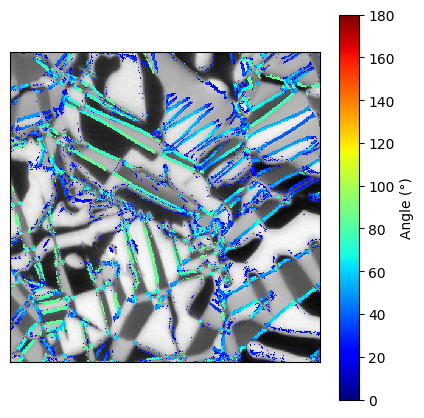

In [168]:
# Filter mode map by domain wall angle range
filtered_mode_map = np.where((mode_map*180/np.pi >= 20) & (mode_map*180/np.pi < 90), mode_map*180/np.pi, np.nan)

# Plot the filtered mode map, keeping the same vmin/vmax so the color scale remains consistent with full mode map
plt.figure(figsize=(5, 5))
plt.imshow(background_img, cmap='binary_r', interpolation='none')
im = plt.imshow(filtered_mode_map, vmin=0, vmax=180, cmap='jet', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.colorbar(im, label="Angle (°)")
plt.show()

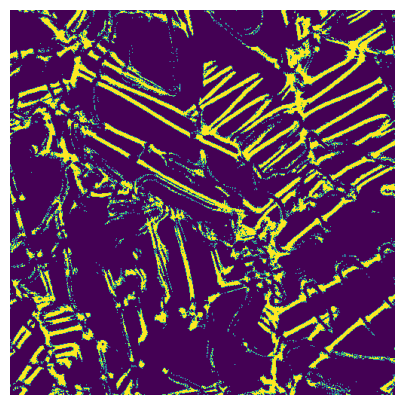

In [169]:
# Create boolean mask of filtered mode map
bool_mask = ~np.isnan(filtered_mode_map)

plt.figure(figsize=(5, 5))
plt.imshow(bool_mask)
plt.axis('off')
plt.show()

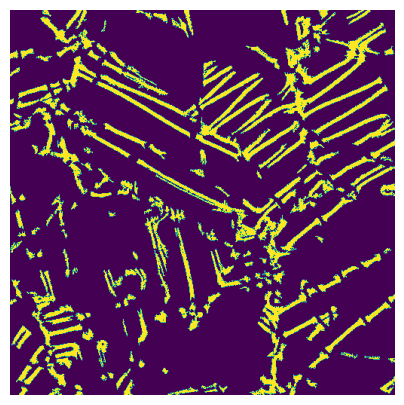

In [172]:
# Clean up boolean mask of filtered mode map

from skimage.morphology import remove_small_objects

clean_mask = remove_small_objects(bool_mask, min_size=30)

plt.figure(figsize=(5, 5))
plt.imshow(clean_mask)
plt.axis('off')
plt.show()

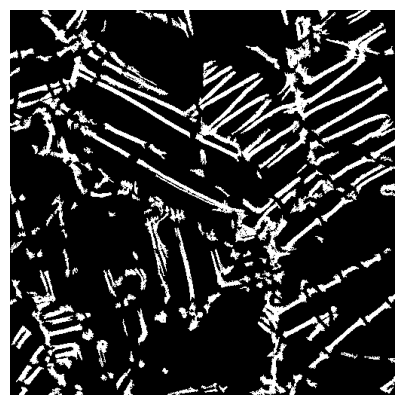

In [173]:
# Covert boolean mask to format usable as input to OpenCV

dst = (clean_mask * 255).astype('uint8')

plt.figure(figsize=(5, 5))
plt.imshow(dst, cmap='gray') # Display in grayscale
plt.axis('off')
plt.show()

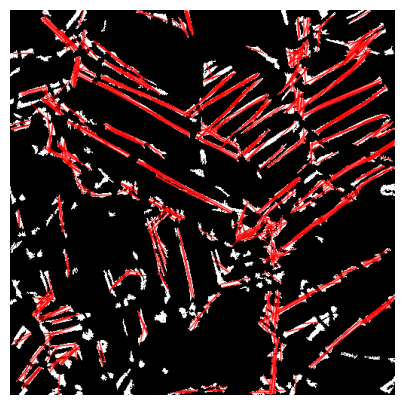

In [174]:
# Probabilistic Hough Line Transform to detect straight lines
import cv2 as cv

cdstP = cv.cvtColor(dst, cv.COLOR_GRAY2BGR)

linesP = cv.HoughLinesP(
    dst, 
    rho=1, 
    theta=np.pi/180, 
    threshold=60, 
    minLineLength=20, 
    maxLineGap=5
)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv.LINE_AA)

# Convert BGR (OpenCV format) to RGB (Matplotlib format)
img_rgb = cv.cvtColor(cdstP, cv.COLOR_BGR2RGB)

plt.figure(figsize=(5, 5))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [165]:
# Function to merge duplicate lines detected by HoughLinesP()

def merge_lines(lines, dist_threshold=10, angle_threshold_deg=5):
    """
    Merge nearby line segments into single, longer lines if they are nearly parallel
    and their endpoints are in close proximity.

    Parameters
    ----------
    lines : ndarray
        The list of raw line segments found by the initial detection.
        (Output from cv.HoughLinesP)
    dist_threshold : float
        Max pixel distance between any two endpoints to consider lines for a merge.
    angle_threshold_deg : float
        Max difference in degrees between line orientations to consider them parallel.

    Returns
    -------
    merged : list of arrays
        List of merged line coordinates [x1, y1, x2, y2] as integer arrays.
    """
    if lines is None: return []
    
    processed_lines = []
    for l in lines:
        x1, y1, x2, y2 = l[0]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1)) % 180
        # Store start and end points separately
        p1 = np.array([x1, y1])
        p2 = np.array([x2, y2])
        processed_lines.append({'p1': p1, 'p2': p2, 'angle': angle})

    merged = []
    used = [False] * len(processed_lines)

    for i in range(len(processed_lines)):
        if used[i]: continue
        
        group = [processed_lines[i]]
        used[i] = True
        
        for j in range(i + 1, len(processed_lines)):
            if used[j]: continue
            
            angle_diff = abs(processed_lines[i]['angle'] - processed_lines[j]['angle'])
            
            # Check distances between all 4 possible end-point combinations
            # (Start-Start, Start-End, End-Start, End-End)
            dists = [
                np.linalg.norm(processed_lines[i]['p1'] - processed_lines[j]['p1']),
                np.linalg.norm(processed_lines[i]['p1'] - processed_lines[j]['p2']),
                np.linalg.norm(processed_lines[i]['p2'] - processed_lines[j]['p1']),
                np.linalg.norm(processed_lines[i]['p2'] - processed_lines[j]['p2'])
            ]
            min_dist = min(dists)
            
            # If they are parallel AND any two ends are close, group them
            if angle_diff < angle_threshold_deg and min_dist < dist_threshold:
                group.append(processed_lines[j])
                used[j] = True
        
        # To merge into 1 long line, find the two points furthest from each other
        all_pts = []
        for g in group:
            all_pts.append(g['p1'])
            all_pts.append(g['p2'])
        
        # Find the "extreme" points to define the new long line
        # This prevents the "averaging" effect from shrinking the line
        max_d = -1
        best_pair = (all_pts[0], all_pts[1])
        for pA in all_pts:
            for pB in all_pts:
                d = np.linalg.norm(pA - pB)
                if d > max_d:
                    max_d = d
                    best_pair = (pA, pB)
        
        final_coords = np.array([best_pair[0][0], best_pair[0][1], best_pair[1][0], best_pair[1][1]]).astype(int)
        merged.append(final_coords)
        
    return merged

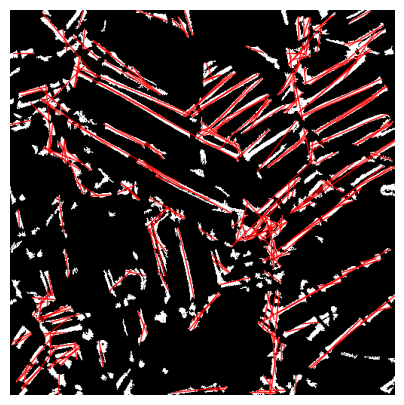

In [175]:
# Merge duplicate lines detected by HoughLinesP()

merged_lines = merge_lines(linesP, dist_threshold=15, angle_threshold_deg=3)

plt.figure(figsize=(5, 5))
plt.imshow(dst, cmap='gray')
for line in merged_lines:
    x1, y1, x2, y2 = line
    plt.plot([x1, x2], [y1, y2], color='red', linewidth=1, alpha=0.8)
plt.axis('off')
plt.show()
